# Project Title

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

- Stakeholder - Literally anyone
- Business problem:
    - Random city in random state is ordering Covid vaccines and is fully aware that not everyone will get the vaccine. Random city wants to know how many Covid vaccines they should be ordering.
- Target: H1N1
- Cost of different errors FP/FN
- False Positive: Model predicts they will get the vaccine, but didn't.
- Ordering too many vaccines and wasting money/material
- False Negative: Model predicts they won't get the vaccine, but did.
- Vaccine shortage. Loss of life.
- Metric:
  - Recall
  - F1-score

In [1]:
!pip install category_encoders

In [2]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import category_encoders as ce

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [3]:
features_df = pd.read_csv('Data/training_set_features.csv')
lables_df = pd.read_csv('Data/training_set_labels.csv')

In [4]:
lables_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


In [5]:
# code here to explore your data

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?
- Can you pipeline your preparation steps to use them consistently in the modeling process?

In [6]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [7]:
features_df.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [8]:
features_df.drop(columns=['respondent_id'], inplace= True)

In [9]:
X = features_df
y = lables_df['h1n1_vaccine']

In [10]:
X['health_insurance'].fillna(2)

0        1.0
1        1.0
2        2.0
3        2.0
4        2.0
        ... 
26702    2.0
26703    1.0
26704    2.0
26705    0.0
26706    1.0
Name: health_insurance, Length: 26707, dtype: float64

In [11]:
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.1, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
num_cols = []
ohe_cols = []
freq_cols = []

for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [13]:
num_cols

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [14]:
ohe_cols

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'census_msa']

In [15]:
freq_cols

['hhs_geo_region', 'employment_industry', 'employment_occupation']

In [16]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
print(numeric_cols)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'health_insurance' 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']


In [17]:
num_transformer = Pipeline(steps=[
    ('minmaxscaler', MinMaxScaler()),
    ('num_imputer', SimpleImputer(strategy='median'))
    ])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('oh_encoder', OneHotEncoder(handle_unknown='ignore'))
])

freq_transformer = Pipeline(steps=[
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)),
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0))
])

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])

In [19]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler()),
                                                 ('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', '...
                                 ['age_group', 'education', 'race', 'sex',
                                  'income_poverty', 'marital_status',
                                  

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How will you analyze the data to arrive at an initial approach?
- How will you iterate on your initial approach to make it better?
- What model type is most appropriate, given the data and the business problem?

## 1. Logistic Regression

### 1.1 Baseline Model

In [20]:
lr_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [21]:
cross_validate(lr_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([0.486444  , 0.38234162, 0.38834596, 0.38835287, 0.38034034]),
 'score_time': array([0.03403735, 0.03002644, 0.03102732, 0.03103209, 0.03203678]),
 'test_score': array([0.83852095, 0.84109525, 0.84039317, 0.83594664, 0.83243623]),
 'train_score': array([0.83881348, 0.8381699 , 0.83910601, 0.83951556, 0.84021765])}

In [22]:
lr_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [23]:
lr_preds = lr_clf.predict(X_val)

In [24]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, lr_preds)))
print('recall {:0.3f}'.format(recall_score(y_val, lr_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , lr_preds)))

accuracy: 0.826
recall 0.403
f1: 0.503
roc_auc: 0.673


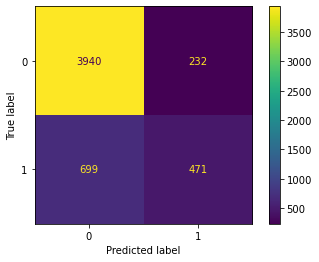

In [25]:
plot_confusion_matrix(lr_clf, X_val, y_val)

### 1.2 Iteration

In [26]:
params={'classifier__penalty':['l2', 'l1','elasticnet'],
        'classifier__C':[ 0.1, 1, 10, 100, 101, 102,103,104,105],
        'classifier__class_weight':['balanced', None]
       }

In [27]:
grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='f1')
output = grid_clf.fit(X_train, y_train)

In [28]:
print('Best Param:{0}, Best f1:{1:.3f}'.format(grid_clf.best_params_, 
                                                  grid_clf.best_score_))

Best Param:{'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2'}, Best f1:0.581


### 1.3 Model 2.0

In [29]:
output.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [30]:
val_preds = output.best_estimator_.predict(X_val)

In [91]:
cross_validate(output.best_estimator_, X_train, y_train, return_train_score=True)

{'fit_time': array([0.34330726, 0.35232186, 0.34831691, 0.34730935, 0.36032653]),
 'score_time': array([0.03003383, 0.03002548, 0.03102827, 0.0300262 , 0.03102732]),
 'test_score': array([0.78071612, 0.78282237, 0.78960917, 0.77416335, 0.76480225]),
 'train_score': array([0.78106717, 0.77919495, 0.77831734, 0.78083314, 0.78510414])}

In [31]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, val_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, val_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, val_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , val_preds)))

accuracy: 0.776
recall: 0.708
f1: 0.581
roc_auc: 0.751


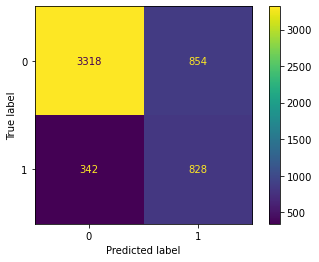

In [32]:
plot_confusion_matrix(output.best_estimator_, X_val, y_val)

### 1.4 ROC Curve

In [33]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

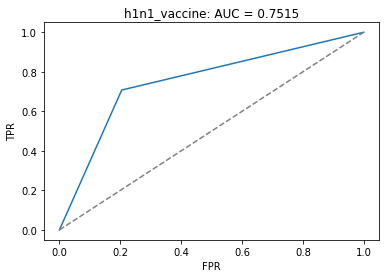

In [34]:
fig, ax = plt.subplots()
plot_roc(
    y_val, 
    val_preds, 
    'h1n1_vaccine',
    ax = ax
)

In [35]:
X_pre = preprocessor.fit_transform(X_train)
X_pre

array([[0.66666667, 0.5       , 0.        , ..., 0.157641  , 0.34172712,
        0.37280599],
       [0.33333333, 0.5       , 0.        , ..., 0.10648256, 0.09314299,
        0.37280599],
       [0.66666667, 0.5       , 0.        , ..., 0.157641  , 0.49815118,
        0.50376784],
       ...,
       [0.66666667, 0.5       , 0.        , ..., 0.10648256, 0.49815118,
        0.50376784],
       [0.66666667, 1.        , 0.        , ..., 0.11729464, 0.49815118,
        0.50376784],
       [1.        , 1.        , 0.        , ..., 0.07666745, 0.09314299,
        0.37280599]])

In [36]:
importance = output.best_estimator_['classifier'].coef_[0]
#for feat, importance in zip(X_pre, output.best_estimator_['classifier'].coef_[0]):
#    print('feature: {f}, importance: {i}'.format(f=feat, i=importance))
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.17150
Feature: 1, Score: 0.23153
Feature: 2, Score: 0.33135
Feature: 3, Score: -0.00904
Feature: 4, Score: 0.28014
Feature: 5, Score: 0.04385
Feature: 6, Score: -0.25205
Feature: 7, Score: -0.01514
Feature: 8, Score: 0.02999
Feature: 9, Score: 2.13730
Feature: 10, Score: -0.55861
Feature: 11, Score: 0.12150
Feature: 12, Score: 0.19854
Feature: 13, Score: 0.74392
Feature: 14, Score: 0.17041
Feature: 15, Score: 2.42063
Feature: 16, Score: 1.44422
Feature: 17, Score: -0.02622
Feature: 18, Score: 0.26919
Feature: 19, Score: 0.65140
Feature: 20, Score: -0.38106
Feature: 21, Score: -0.02398
Feature: 22, Score: -0.20584
Feature: 23, Score: -0.24574
Feature: 24, Score: -0.31868
Feature: 25, Score: -0.32815
Feature: 26, Score: -0.03387
Feature: 27, Score: 0.12277
Feature: 28, Score: -0.16960
Feature: 29, Score: -0.37231
Feature: 30, Score: -0.04459
Feature: 31, Score: -0.17119
Feature: 32, Score: -0.04599
Feature: 33, Score: -0.39183
Feature: 34, Score: -0.13577
Feature: 3

In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21365 entries, 18127 to 2732
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 21288 non-null  float64
 1   h1n1_knowledge               21270 non-null  float64
 2   behavioral_antiviral_meds    21312 non-null  float64
 3   behavioral_avoidance         21204 non-null  float64
 4   behavioral_face_mask         21348 non-null  float64
 5   behavioral_wash_hands        21337 non-null  float64
 6   behavioral_large_gatherings  21296 non-null  float64
 7   behavioral_outside_home      21300 non-null  float64
 8   behavioral_touch_face        21260 non-null  float64
 9   doctor_recc_h1n1             19644 non-null  float64
 10  doctor_recc_seasonal         19644 non-null  float64
 11  chronic_med_condition        20576 non-null  float64
 12  child_under_6_months         20696 non-null  float64
 13  health_worker

From feature importance, we realized feature 9, 14, 15 has high impact coefficient. Based on our encoded dataset:
- 9 => doctor_recc_h1n1
- 14 => opinion_h1n1_vacc_effective
- 15 => opinion_h1n1_risk

## 2. Naive Bayesian

### 2.1 Baseline Model

In [38]:
from sklearn.naive_bayes import GaussianNB

In [39]:
nb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

In [40]:
cross_validate(nb_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([0.17115569, 0.17215681, 0.24021673, 0.2252121 , 0.18316698]),
 'score_time': array([0.03403115, 0.0350318 , 0.03803492, 0.03403091, 0.04103684]),
 'test_score': array([0.76246197, 0.75567517, 0.76503627, 0.75310087, 0.75684531]),
 'train_score': array([0.76129183, 0.75696232, 0.75520711, 0.75965364, 0.75924409])}

In [41]:
nb_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [42]:
nb_preds = nb_clf.predict(X_val)

In [43]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, nb_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, nb_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, nb_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , nb_preds)))

accuracy: 0.756
recall: 0.623
f1: 0.528
roc_auc: 0.708


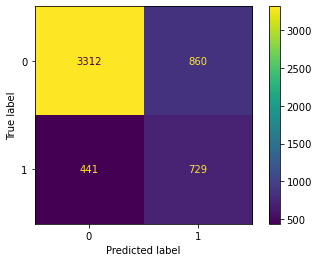

In [44]:
plot_confusion_matrix(nb_clf, X_val, y_val)

### 2.2 Tuning

In [45]:
params={'classifier__var_smoothing':np.logspace(0,-9, num=100),
       }

In [46]:
grid_nb = GridSearchCV(nb_clf, param_grid=params, scoring='f1')
output_nb = grid_nb.fit(X_train, y_train)

In [47]:
print('Best Param:{0}, Best f1:{1:.3f}'.format(output_nb.best_params_, 
                                                  output_nb.best_score_))

Best Param:{'classifier__var_smoothing': 0.1873817422860384}, Best f1:0.542


### 2.2 Model 2.0

In [48]:
output_nb.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [49]:
nb_preds2 = output_nb.best_estimator_.predict(X_val)

In [50]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, nb_preds2)))
print('recall: {:0.3f}'.format(recall_score(y_val, nb_preds2)))
print('f1: {:0.3f}'.format(f1_score(y_val, nb_preds2)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , nb_preds2)))

accuracy: 0.787
recall: 0.574
f1: 0.541
roc_auc: 0.710


In [92]:
cross_validate(output_nb.best_estimator_, X_train, y_train, return_train_score=True)

{'fit_time': array([0.18516898, 0.17114782, 0.17015457, 0.16915393, 0.16614318]),
 'score_time': array([0.03603244, 0.03303003, 0.03403068, 0.03804255, 0.03403115]),
 'test_score': array([0.79428973, 0.79663   , 0.79850222, 0.78656681, 0.78820501]),
 'train_score': array([0.79510882, 0.79189094, 0.79253452, 0.79440674, 0.7949333 ])}

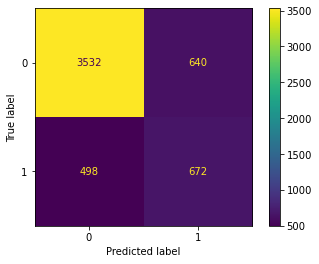

In [51]:
plot_confusion_matrix(output_nb.best_estimator_, X_val, y_val)

### 2.4 ROC Curve

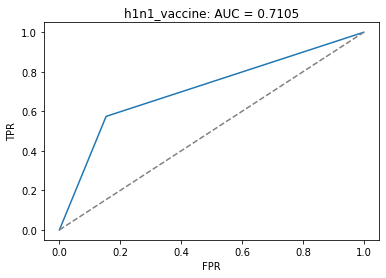

In [52]:
fig, ax = plt.subplots()
plot_roc(
    y_val, 
    nb_preds2, 
    'h1n1_vaccine',
    ax = ax
)

## 3. KNN

## 3.1 Baseline Model

In [53]:
from sklearn.neighbors import KNeighborsClassifier

In [54]:
knn_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [55]:
knn_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [56]:
knn_preds = knn_clf.predict(X_val)

In [57]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, knn_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, knn_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, knn_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , knn_preds)))

accuracy: 0.798
recall: 0.250
f1: 0.352
roc_auc: 0.601


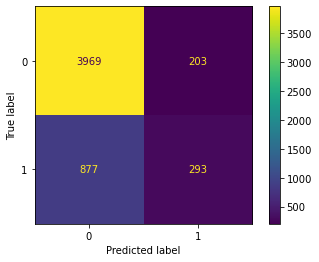

In [58]:
plot_confusion_matrix(knn_clf, X_val, y_val)

## Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [66]:
cross_validate(rf_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([1.99832654, 2.0228405 , 2.08890867, 1.98981857, 2.15549064]),
 'score_time': array([0.11061549, 0.14613318, 0.11910057, 0.11509895, 0.11010766]),
 'test_score': array([0.83594664, 0.83781886, 0.83454248, 0.83196817, 0.82986192]),
 'train_score': array([1.        , 1.        , 0.99988299, 1.        , 1.        ])}

In [67]:
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [68]:
rf_preds = rf_clf.predict(X_val)

In [69]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, rf_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, rf_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, rf_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , rf_preds)))

accuracy: 0.830
recall: 0.373
f1: 0.490
roc_auc: 0.665


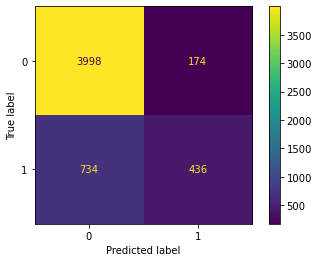

In [70]:
plot_confusion_matrix(rf_clf, X_val, y_val)

### 5.2 Tuning

In [122]:
rf_params={#'classifier__n_estimators':[100, 150, 200,250, 300],
           #'classifier__criterion':['gini', 'entropy'],
           #'classifier__min_samples_split': [2, 8, 16, 20],
           #'classifier__min_samples_leaf':[1, 8, 12, 18],
           #'classifier__max_features':['auto','log2', None],
           #'classifier__max_depth':[None, 6, 8, 10, 12],
           #'classifier__max_leaf_nodes':[None, 10, 20, 30],
           #'classifier__class_weight':['balanced', 'balanced_subsample', None]
           
       }

In [123]:
grid_rf = GridSearchCV(rf_clf3, param_grid=rf_params, scoring='f1')
output_rf = grid_rf.fit(X_train, y_train)

In [124]:
print('Best Param:{0}, Best f1:{1:.3f}'.format(grid_rf.best_params_, 
                                               grid_rf.best_score_))

Best Param:{'classifier__min_samples_leaf': 1}, Best f1:0.534


- class_weight = None
- criterion = entropy
- n_estimators = 300
- class weight = None
- max features = None
- max_leaf_nodes = None
- max_depth = None
- min_samples_leaf = 1
- min samples split = larger = less overfitting => 100 or over depending on cross-validate result

In [71]:
rf_clf2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators = 300, criterion = 'entropy', max_features = None, min_samples_split = 20))
])

In [72]:
rf_clf2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [79]:
cross_validate(rf_clf2, X_train, y_train, return_train_score=True)

{'fit_time': array([24.2161243 , 23.86299181, 23.61600971, 24.33358049, 23.16693902]),
 'score_time': array([0.23221111, 0.2482338 , 0.23221111, 0.22519732, 0.22920823]),
 'test_score': array([0.83875497, 0.8432015 , 0.83735081, 0.8415633 , 0.82986192]),
 'train_score': array([0.90580388, 0.90978235, 0.90597941, 0.90831968, 0.90539434])}

In [73]:
rf_preds2 = rf_clf2.predict(X_val)

In [74]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, rf_preds2)))
print('recall: {:0.3f}'.format(recall_score(y_val, rf_preds2)))
print('f1: {:0.3f}'.format(f1_score(y_val, rf_preds2)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , rf_preds2)))

accuracy: 0.830
recall: 0.432
f1: 0.527
roc_auc: 0.687


In [131]:
rf_clf3= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators = 300, 
                                          criterion = 'entropy', 
                                          max_features = None, 
                                          min_samples_split = 100, 
                                          max_depth = None))
])

In [126]:
cross_validate(rf_clf3, X_train, y_train, return_train_score=True)

{'fit_time': array([18.45081711, 18.00901055, 17.98515844, 17.90959954, 17.64034939]),
 'score_time': array([0.20018172, 0.1891799 , 0.19117379, 0.18817115, 0.18817878]),
 'test_score': array([0.83781886, 0.84437164, 0.83688275, 0.83945706, 0.8279897 ]),
 'train_score': array([0.85098292, 0.85379125, 0.85232857, 0.85478586, 0.85384975])}

In [133]:
rf_clf3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [134]:
rf_preds3 = rf_clf3.predict(X_val)

In [135]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, rf_preds3)))
print('recall: {:0.3f}'.format(recall_score(y_val, rf_preds3)))
print('f1: {:0.3f}'.format(f1_score(y_val, rf_preds3)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , rf_preds3)))

accuracy: 0.832
recall: 0.426
f1: 0.526
roc_auc: 0.686


# Stack 

In [141]:
from sklearn.ensemble import StackingClassifier

In [144]:
stack_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators = 300, 
                                          criterion = 'entropy', 
                                          max_features = None, 
                                          min_samples_split = 100, 
                                          max_depth = None)),
                                                 ('nb',GaussianNB(var_smoothing= 0.1873817422860384))],
                                     final_estimator = LogisticRegression(C= 10, 
                                                                          class_weight= 'balanced', 
                                                                          penalty = 'l2')))
])

In [145]:
cross_validate(stack_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([94.19934416, 90.38978028, 91.58587217, 90.53120828, 91.17334771]),
 'score_time': array([0.20618773, 0.20319271, 0.20318508, 0.20318532, 0.20319295]),
 'test_score': array([0.80879944, 0.80388486, 0.81628832, 0.80154458, 0.79499181]),
 'train_score': array([0.82325064, 0.82600047, 0.82219752, 0.82424526, 0.82447929])}

In [146]:
stack_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [147]:
stack_preds = stack_clf.predict(X_val)

In [148]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, stack_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, stack_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, stack_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , stack_preds)))

accuracy: 0.798
recall: 0.648
f1: 0.585
roc_auc: 0.744


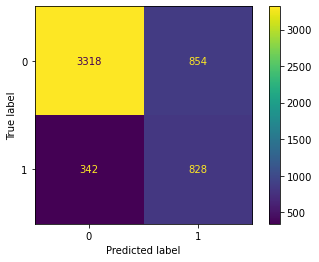

In [151]:
plot_confusion_matrix(output.best_estimator_, X_val, y_val)

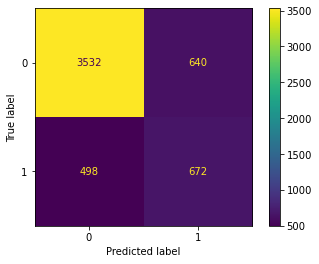

In [150]:
plot_confusion_matrix(output_nb.best_estimator_, X_val, y_val)

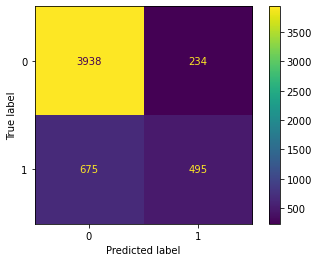

In [153]:
plot_confusion_matrix(rf_clf3 ,X_val,y_val)

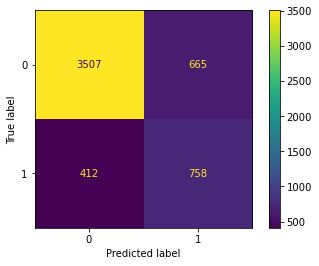

In [149]:
plot_confusion_matrix(stack_clf, X_val, y_val)

In [154]:
stack_clf2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators = 300, 
                                          criterion = 'entropy', 
                                          max_features = None, 
                                          min_samples_split = 100, 
                                          max_depth = None))],
                                     final_estimator = LogisticRegression(C= 10, 
                                                                          class_weight= 'balanced', 
                                                                          penalty = 'l2')))
])

In [155]:
cross_validate(stack_clf2, X_train, y_train, return_train_score=True)

{'fit_time': array([91.72658014, 90.44129801, 91.2247622 , 91.76738453, 90.70667434]),
 'score_time': array([0.19918132, 0.19818044, 0.20218372, 0.20019007, 0.19817233]),
 'test_score': array([0.80833138, 0.80294875, 0.81628832, 0.80201264, 0.79335362]),
 'train_score': array([0.82594196, 0.82839925, 0.82535689, 0.82570793, 0.82939387])}

In [156]:
stack_clf2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [157]:
stack_preds2 = stack_clf2.predict(X_val)

In [158]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, stack_preds2)))
print('recall: {:0.3f}'.format(recall_score(y_val, stack_preds2)))
print('f1: {:0.3f}'.format(f1_score(y_val, stack_preds2)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , stack_preds2)))

accuracy: 0.799
recall: 0.654
f1: 0.588
roc_auc: 0.747


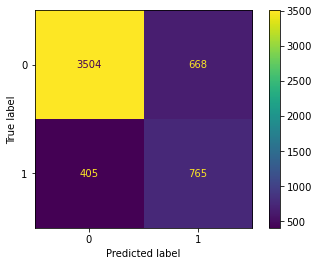

In [159]:
plot_confusion_matrix(stack_clf2, X_val, y_val)

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [84]:
# code here to arrive at a baseline prediction

### First $&(@# Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [85]:
# code here for your first 'substandard' model

In [86]:
# code here to evaluate your first 'substandard' model

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [87]:
# code here to iteratively improve your models

In [88]:
# code here to evaluate your iterations

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [89]:
# code here to show your final model

In [90]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
